## PCA on Census, 

plotting the first to PCs as a scatter, and coloring them by the DSD level poverty label to observe distribution

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import geopandas as gpd
#from thefuzz import process
#from thefuzz import fuzz
import matplotlib.pyplot as plt

# DSD level poverty headcount index got from the department of census and statistics report
dsd_data = pd.read_csv('/lirneasia/data/sei_mapping/processed/dsd_headcount_index.csv')
dsd_data = dsd_data[['dsd_name', 'code_7', 'headcount_index']].copy()
# Sri lanka Shapefile

data_shapefile = gpd.read_file("/lirneasia/data/sei_mapping/sri_lanka_gnd_shape_files/sri_lanka_gnd.shp")

# Read PCA census data

census_data = pd.read_csv('/lirneasia/data/sei_mapping/raw/pca_census.csv')

In [2]:
dsd_data['headcount_index'].describe()

count    14022.000000
mean         8.264671
std          5.151602
min          0.620000
25%          5.530000
50%          7.100000
75%          9.420000
max         45.140000
Name: headcount_index, dtype: float64

In [3]:
def mapping_headcount(headcount):
    
    mapped_value = []
    for x in headcount:
        if x < 7:
            mapped = 1
        elif x < 14:
            mapped = 2
        elif x < 21:
            mapped = 3
        elif x < 28:
            mapped = 4
        elif x < 35:
            mapped = 5
        elif x < 42:
            mapped = 6
        else:
            mapped = 7
        mapped_value.append(mapped)
    
    return mapped_value

In [4]:
merged = census_data.merge(dsd_data, left_on= 'gnd_id', right_on= 'code_7', how= 'inner')

merged.drop(columns=['code_7', 'dsd_name'])

,gnd_id,PC1,headcount_index
0,2103005,-1.852117,5.34
1,2103010,1.544530,5.34
2,2103015,-0.207783,5.34
3,2103020,-3.157110,5.34
4,2103025,-1.223221,5.34
...,...,...,...
14017,9218155,-1.672806,7.32
14018,3242080,6.742357,3.80
14019,3242085,6.443345,3.80
14020,3242110,6.324712,3.80


In [5]:
merged['mapped'] = mapping_headcount(merged['headcount_index'])
merged

,gnd_id,PC1,dsd_name,code_7,headcount_index,mapped
0,2103005,-1.852117,Thumpane,2103005,5.34,1
1,2103010,1.544530,Thumpane,2103010,5.34,1
2,2103015,-0.207783,Thumpane,2103015,5.34,1
3,2103020,-3.157110,Thumpane,2103020,5.34,1
4,2103025,-1.223221,Thumpane,2103025,5.34,1
...,...,...,...,...,...,...
14017,9218155,-1.672806,Warakapola,9218155,7.32,2
14018,3242080,6.742357,Matara Four Gravets,3242080,3.80,1
14019,3242085,6.443345,Matara Four Gravets,3242085,3.80,1
14020,3242110,6.324712,Matara Four Gravets,3242110,3.80,1


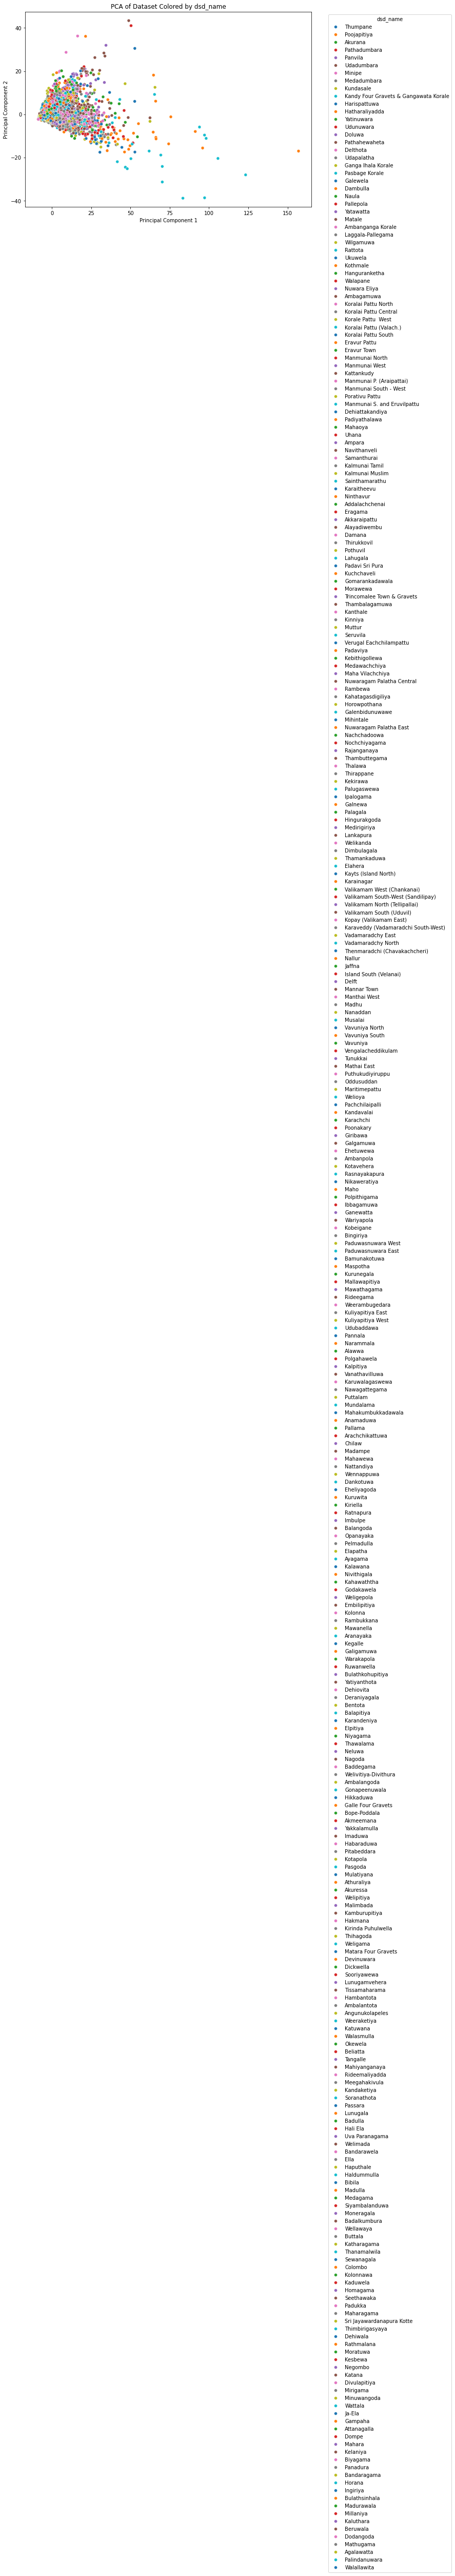

In [28]:

census_data.fillna(0, inplace = True)
merged = census_data.merge(data_shapefile, left_on=census_data.gnd_id, right_on='code_7', how='inner')

merged = merged.drop(columns=['dsd_name'])
merged = merged.merge(dsd_data, left_on=merged.gnd_id, right_on='code_7', how='inner')

X = merged.drop(columns=['prov_name', 'dist_name', 'dsd_name', 'gnd_name', 'geometry', 'code_7', 'headcount_index'])

X.set_index('gnd_id', inplace=True)

y = merged.set_index('gnd_id')[['dsd_name', 'headcount_index']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['gnd_id'] = X.index

# Merge PCA results with labels
pca_df = pca_df.merge(y, left_on='gnd_id', right_index=True)

plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='dsd_name', palette='tab10')
plt.title('PCA of Dataset Colored by dsd_name')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='dsd_name', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('pca_plot.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

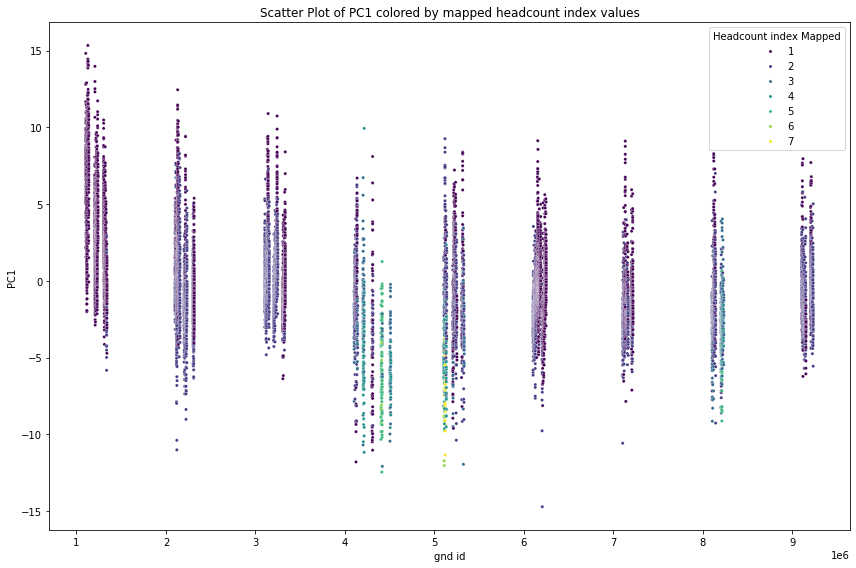

In [13]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged, x='code_7', y='PC1', hue='mapped', palette='viridis', s=10)
plt.title('Scatter Plot of PC1 colored by mapped headcount index values')
plt.xlabel('gnd id')
plt.ylabel('PC1')
plt.legend(title='Headcount index Mapped')

# Use tight_layout to ensure everything fits
plt.tight_layout()

# Save the figure
plt.savefig('pca_scatter_with_headcount_index.png', format='png', dpi=300)

# Show the plot
plt.show()

In [10]:
merged['PC1'].describe()

count    13985.000000
mean        -0.000329
std          3.296913
min        -14.711504
25%         -2.023906
50%         -0.373150
75%          1.708907
max         15.340470
Name: PC1, dtype: float64